In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import logging
import requests

from pyproj import Transformer
from tqdm import tqdm

In [22]:
# Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install tqdm

In [23]:
df=pd.read_csv('tripsWithXY.csv', delimiter=';')

In [24]:
TRADS_df=pd.read_csv('tradsRoutesPt.csv', delimiter=',')

In [128]:
OnlyIntraCityTrips=True

if OnlyIntraCityTrips==True:
    # run this if you want to keep intra-city trips

    # Read the boundary GeoPackage file
    boundary_gdf = gpd.read_file('NetworkBoundary.gpkg')

    # Read the CSV file
    #df=pd.read_csv('tripsWithXY.csv', delimiter=';')
    df['combined'] = df['IDNumber'] + '_' + df['TripNumber'].astype(str)

    # Convert dataframe to GeoDataFrame for start coordinates
    start_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['StartEasting'], df['StartNorthing']), crs=boundary_gdf.crs)

    # Convert dataframe to GeoDataFrame for end coordinates
    end_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['EndEasting'], df['EndNorthing']), crs=boundary_gdf.crs)

    intra_city_tripsO = gpd.sjoin(start_gdf, boundary_gdf, predicate='within')
    intra_city_tripsD = gpd.sjoin(end_gdf, boundary_gdf, predicate='within')

    # Check if the combined values exist in the other GeoDataFrame
    is_in_end_gdf = intra_city_tripsO['combined'].isin(intra_city_tripsD['combined'])

    intra_city_tripsO[is_in_end_gdf]['combined']

    # Filter start_gdf based on the condition
    filtered_df = df['combined'].isin(intra_city_tripsO[is_in_end_gdf]['combined'])
    #sub_df=df[filtered_df]

    #merged_gdf = pd.merge(start_within_boundary, end_within_boundary, on=['IDNumber','TripNumber'], how='inner', suffixes=('_x', ''))

    #start_gdf.to_file('start_coordinates.shp')
    #end_gdf.to_file('end_coordinates.shp')


In [134]:
len(df)

31129

In [26]:
# Set up logging configuration
#logging.basicConfig(filename='log.txt', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [27]:
# Function to make a request to OTP API
def make_otp_request(params):
    # Define the OTP server URL
    otp_server_url = 'http://localhost:8080/otp/routers/{routerId}/plan'
    response = requests.get(otp_server_url, params=params)

    return response.json()

def example_request(xfrom, yfrom, xto, yto):
    # Specify the request parameters
    params = {
        'fromPlace': str(xfrom) + ',' + str(yfrom),  # Origin coordinates
        'toPlace': str(xto) + ',' + str(yto),    # Destination coordinates
        'time': '9:00am',                                      # Time of travel
        'date': '08-29-2022',                                  # Date of travel
        'mode': 'TRANSIT,WALK',                                # Modes of transport
        'arriveBy': 'false',                                   # Departure or arrival time
        'wheelchair': 'false',                                 # Wheelchair accessibility
        'showIntermediateStops': 'true',                       # Show intermediate stops
        'debugItineraryFilter': 'false',                       # Enable itinerary filtering
        'locale': 'en',                                        # Language/locale
        'baseLayer': 'OSM Standard Tiles'                      # Base map layer
    }

    # Make the request to OTP API
    response = make_otp_request(params)

    # Process the response
    # Example: Print the itineraries
    return response

class MyObject:
    def __init__(self, itid, walk_time, transit_time, waitingTime, walkDistance, transfers, nlegs):
        self.itid = itid
        self.walk_time = walk_time
        self.transit_time = transit_time
        self.waitingTime = waitingTime
        self.walkDistance = walkDistance
        self.transfers = transfers
        self.nlegs = nlegs
        
objects = []

In [28]:
df['walk_time'] = None
df['transit_time'] = None
df['waitingTime'] = None
df['walkDistance'] = None
df['transfers'] = None
df['nlegs'] = None

# Define the transformer for coordinate conversion
transformer = Transformer.from_crs('epsg:27700', 'epsg:4326')

pbar = tqdm(total=len(df))     
for index, row in df.iterrows():
    x_from = row['StartEasting']
    y_from = row['StartNorthing']
    x_to = row['EndEasting']
    y_to = row['EndNorthing']
    
    x_from, y_from = transformer.transform(x_from, y_from)
    x_to, y_to = transformer.transform(x_to, y_to)
    
    if pd.isna(x_from) or pd.isna(y_from) or pd.isna(x_to) or pd.isna(y_to):
        continue
    elif np.isinf(x_from) or np.isinf(y_from) or np.isinf(x_to) or np.isinf(y_to):
        continue
    else:
        response=example_request(x_from, y_from, x_to, y_to)
        for obj in response['plan']['itineraries']:
            my_obj = MyObject(row['IDNumber']+'-'+str(row['TripNumber']), 
                              obj['walkTime'], 
                              obj['transitTime'], 
                              obj['waitingTime'],
                              obj['walkDistance'], 
                              obj['transfers'], 
                              obj['legs'])
            
            objects.append(my_obj)

        # Store the calculated times in the DataFrame
        #df.at[index, 'walk_time'] = k['walkTime']/60
        #df.at[index, 'transit_time'] = k['transitTime']/60
        #df.at[index, 'waitingTime'] = k['waitingTime']/60
        #df.at[index, 'walkDistance'] = k['walkDistance']
        #df.at[index, 'transfers'] = k['transfers']
        #df.at[index, 'nlegs'] = len(k['legs'])

        # Log the origin/destination pair and the calculated times
        #logging.info(f"Origin: ({x_from}, {y_from}), Destination: ({x_to}, {y_to}), Walk Time: {walk_time}, Transit Time: {transit_time}")

        #if (index + 1) % 100 == 0:
        #    print(index)
    pbar.update(1)
pbar.close()

100%|██████████████████████████████████▉| 31092/31129 [3:03:49<00:13,  2.82it/s]


In [29]:
# df2.to_csv('PtDataOTP.csv')

(105767, 7)

In [30]:
df2 = pd.DataFrame(columns=['itid','walk_time','transit_time','waitingTime','walkDistance','transfers'])

for k in objects:
    df2.loc[len(df2)] = [k.__dict__['itid'],
               k.__dict__['walk_time'], 
               k.__dict__['transit_time'],
               k.__dict__['waitingTime'],
               k.__dict__['walkDistance'],
               k.__dict__['transfers']]

In [31]:
df2['total_time']=(df2['walk_time'] +df2['transit_time'])

In [121]:
df2.to_csv('PtDataOTP.csv')

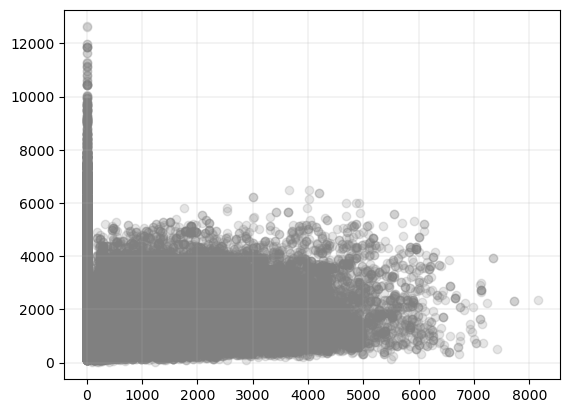

In [32]:
plt.scatter(df2['transit_time'], df2['walk_time'], alpha=0.2, color='gray')
plt.grid(True, lw=0.2)

In [33]:
# Group by 'id' and get the index of the row with the lowest walk travel time in each group
idx = df2.groupby('itid')['total_time'].idxmin()

# Use the obtained index to access the corresponding transit travel time value
ExtractedResults = df2.loc[idx, ['itid', 'walk_time', 'transit_time', 'walkDistance']]

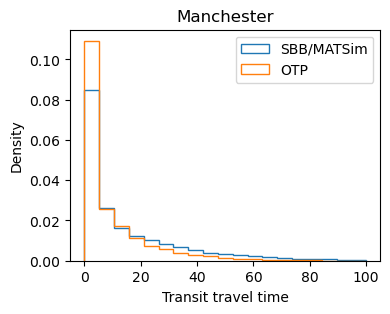

In [147]:
f=TRADS_df.itid.isin(df[filtered_df]['itid'])
f2=ExtractedResults.itid.isin(df[filtered_df]['itid'])

fig, ax=plt.subplots(figsize=(4,3))

bins=np.linspace(0,100, 20)

# Plot the histogram
ax.hist(TRADS_df['ptTravelTime'][f]/60, bins=bins, histtype='step', label='SBB/MATSim', density=True)
#ax.hist(merged_df['transit_time'].astype(float)[f], bins=bins, histtype='step', label='OpenTripPlanner')
#(df.groupby('itid').agg(['mean']).reset_index()['transit_time']/60).hist(ax=ax, histtype='step', bins=bins, label='OpenTripPlanner')

ax.hist(ExtractedResults['transit_time'][f2]/60, bins=bins, histtype='step', label='OTP', density=True)

# Add labels and title
ax.set_xlabel('Transit travel time')
ax.set_ylabel('Density')
ax.set_title('Manchester')

ax.legend()


# Set the limits for the x and y axes
#x_limits = [0,100]  # Example x-axis limits
#y_limits = [0,0.2]  # Example y-axis limits

#ax.set_xlim(x_limits)
#ax.set_ylim(y_limits)

#plt.yscale('log')

fig.savefig('ttd-{}.jpg'.format('Transit travel time'.replace(" ","")), dpi=400, bbox_inches='tight') # bbox_inches='tight'


# Display the plot
plt.show()

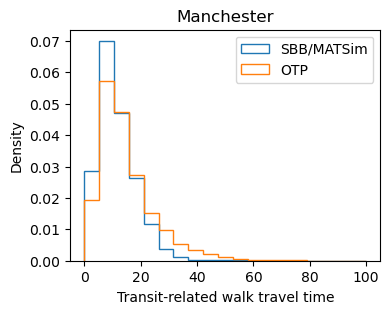

In [105]:
WalkingSpeedOTP=4.83 # km/h
WalkingSpeedSBB=1.*3600/10**3 # km/h

fig, ax=plt.subplots(figsize=(4,3))

bins=np.linspace(0,100, 20)

# Plot the histogram
ax.hist(TRADS_df['walkTravelTime']/60*WalkingSpeedSBB/WalkingSpeedOTP, bins=bins, histtype='step', label='SBB/MATSim', density=True)
#ax.hist(merged_df['transit_time'].astype(float)[f], bins=bins, histtype='step', label='OpenTripPlanner')
#(df.groupby('itid').agg(['mean']).reset_index()['transit_time']/60).hist(ax=ax, histtype='step', bins=bins, label='OpenTripPlanner')

ax.hist((ExtractedResults['walk_time']/60), bins=bins, histtype='step', label='OTP', density=True)

# Add labels and title
ax.set_xlabel('Transit-related walk travel time')
ax.set_ylabel('Density')
ax.set_title('Manchester')

ax.legend()


# Set the limits for the x and y axes
#x_limits = [0,100]  # Example x-axis limits
#y_limits = [0,0.1]  # Example y-axis limits
#ax.set_xlim(x_limits)
#ax.set_ylim(y_limits)

# Display the plot
fig.savefig('ttd-{}.jpg'.format('Transit-related walk travel time'.replace(" ","")), dpi=400, bbox_inches='tight') # bbox_inches='tight'

plt.show()

In [37]:
#dfA=df.groupby('itid').agg(['min']).reset_index()[['itid','walk_time','walkDistance']]
#dfA=dfA.droplevel(1, axis=1)

In [38]:
TRADS_df['itid'] = TRADS_df['IDNumber'] + '-' + TRADS_df['TripNumber'].astype(str)

In [39]:
points=pd.merge(TRADS_df[['itid','walkTravelTime','walkDistance','ptTravelTime']], ExtractedResults[['itid','walk_time','walkDistance','transit_time']], on='itid')

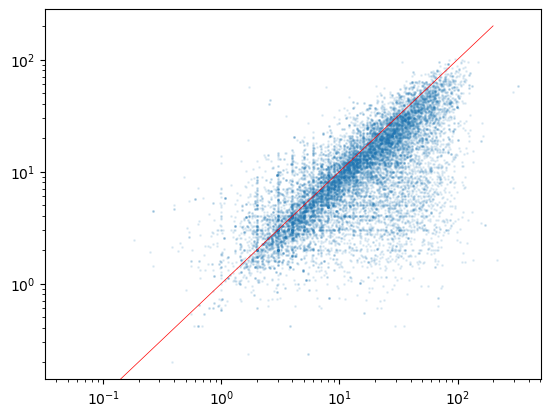

In [40]:
#plt.plot((points['walkTravelTime']/60)[points['walkTravelTime']/60<100], lw=0.1)
#plt.plot((points['walk_time']/60)[points['walkTravelTime']/60<100], lw=0.1)

threshold=200


from scipy import stats

x=points['ptTravelTime']/60
y=points['transit_time']/60

# Remove NaN or None values
valid_indices = np.logical_and(~np.isnan(x), ~np.isnan(y))
x = x[valid_indices]
y = y[valid_indices]

#x=np.log(x)
#y=np.log(y)

# Fit linear regression model
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)




plt.plot((points['ptTravelTime']/60),
         (points['transit_time']/60), 'o', alpha=0.1, ms=1)

#plt.xlim(0, threshold)
#plt.ylim(0, threshold)

plt.plot([0, threshold],[0, threshold], color='red', lw=0.5)
#plt.plot(x, intercept + slope * x, color='yellow', label='Regression Line')

plt.xscale('log')
plt.yscale('log')

In [92]:
points['SBB_total_travel_time']=points['ptTravelTime']+points['walkTravelTime']*WalkingSpeedSBB/WalkingSpeedOTP
points['OTP_total_travel_time']=points['transit_time']+points['walk_time']

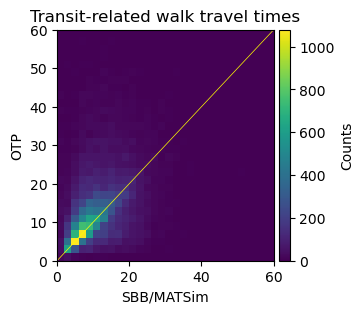

after removing NA, NAN values: 1.0
matching rate  0.33587291295185606
after removing non-transit trips: 1.0


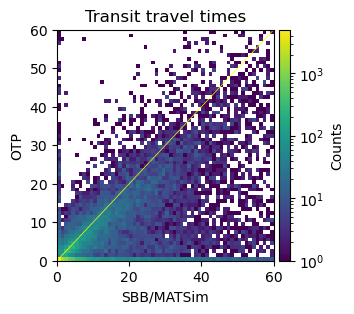

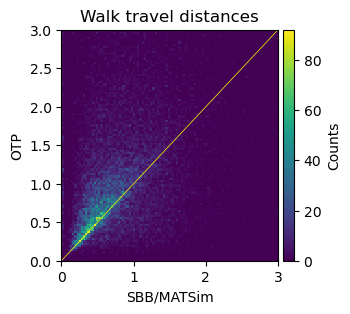

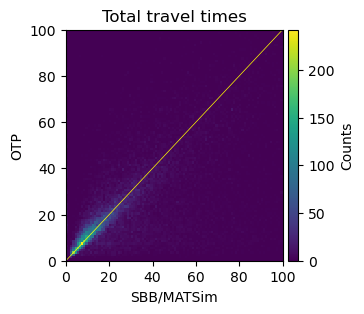

In [148]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def compare(x, y, title_lab, threshold=60, bins=30, norm='linear'):
    fig, ax=plt.subplots(figsize=(3,3)) # tight_layout=False

    #threshold=threshold
    xmin=0
    xmax=threshold
    ymin=0
    ymax=threshold

    im=ax.hist2d( x, y, bins=bins, range=[[xmin, xmax], [ymin, ymax]], cmin=0, norm=norm)

    # Add colorbar for reference
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar=plt.colorbar(im[3], cax=cax)
    cbar.set_label('Counts')
    ax.plot([0, threshold],[0, threshold], color='yellow', lw=0.5)

    ax.set_title(title_lab)
    ax.set_xlabel('SBB/MATSim')
    ax.set_ylabel('OTP')
    
    fig.savefig('tt-{}.jpg'.format(title_lab.replace(" ","")), dpi=400, bbox_inches='tight') # bbox_inches='tight'
    plt.show()
    
    
compare(points['walkTravelTime']/60*WalkingSpeedSBB/WalkingSpeedOTP, 
        points['walk_time']/60,
        'Transit-related walk travel times',
        threshold=60,
        bins=30)


f=points.itid.isin(df[filtered_df]['itid'])

x=points['ptTravelTime'][f]/60
y=points['transit_time'][f]/60
avalue=len(x)

# Remove NaN or None values
#valid_indices = np.logical_and(~np.isnan(x), ~np.isnan(y))
#x = x[valid_indices]
#y = y[valid_indices]
print('after removing NA, NAN values:' ,len(x)/avalue)

print('matching rate ',sum(x[y==0]==y[y==0])/sum(y==0))

#x = x[y>0]
#y = y[y>0]
print('after removing non-transit trips:' ,len(x)/avalue)

compare(x, 
        y,
        'Transit travel times',
        threshold=60,
        bins=60,
        norm='log')

compare(points['walkDistance_x']/10**3, 
        points['walkDistance_y']/10**3,
        'Walk travel distances',
        threshold=3*1000/10**3,
        bins=100)

compare(points['SBB_total_travel_time']/60, 
        points['OTP_total_travel_time']/60,
        'Total travel times',
        threshold=100,
        bins=100)

Text(0.1, 0.75, 'p-value: 0.00e+00')

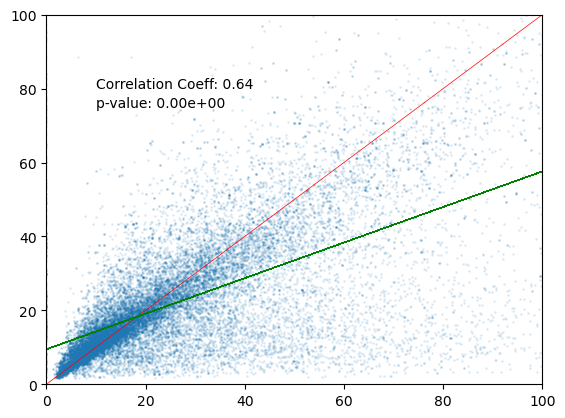

In [46]:
threshold=100

x=points['SBB_total_travel_time']/60
y=points['OTP_total_travel_time']/60

# Remove NaN or None values
valid_indices = np.logical_and(~np.isnan(x), ~np.isnan(y))
x = x[valid_indices]
y = y[valid_indices]

#x=np.log(x)
#y=np.log(y)

# Fit linear regression model
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)


plt.plot((points['SBB_total_travel_time']/60),
         (points['OTP_total_travel_time']/60), 'o', alpha=1./10, ms=1)

plt.xlim(0, threshold)
plt.ylim(0, threshold)

plt.plot([0, threshold],[0, threshold], color='red', lw=0.5)
plt.plot(x, intercept + slope * x, color='green', label='Regression Line', lw=0.5)

r_squared = r_value ** 2

# Display the regression statistics
#plt.text(0.1, 0.9, f'R-squared: {r_squared:.2f}', transform=plt.gca().transAxes)
#plt.text(0.1, 0.85, f'Slope: {slope:.2f}', transform=plt.gca().transAxes)
plt.text(0.1, 0.8, f'Correlation Coeff: {r_value:.2f}', transform=plt.gca().transAxes)
plt.text(0.1, 0.75, f'p-value: {p_value:.2e}', transform=plt.gca().transAxes)


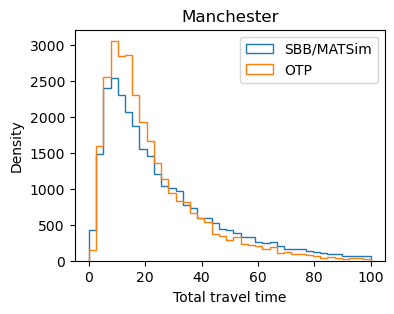

In [104]:
fig, ax=plt.subplots(figsize=(4,3))

bins=np.linspace(0,100, 40)

# Plot the histogram
ax.hist(points['SBB_total_travel_time']/60, bins=bins, histtype='step', label='SBB/MATSim', density=False)
#ax.hist(merged_df['transit_time'].astype(float)[f], bins=bins, histtype='step', label='OpenTripPlanner')
#(df.groupby('itid').agg(['mean']).reset_index()['transit_time']/60).hist(ax=ax, histtype='step', bins=bins, label='OpenTripPlanner')

ax.hist(points['OTP_total_travel_time']/60, bins=bins, histtype='step', label='OTP', density=False)

# Add labels and title
ax.set_xlabel('Total travel time')
ax.set_ylabel('Density')
ax.set_title('Manchester')

ax.legend()


# Set the limits for the x and y axes
#x_limits = [0,100]  # Example x-axis limits
#y_limits = [0,0.2]  # Example y-axis limits

#ax.set_xlim(x_limits)
#ax.set_ylim(y_limits)

#plt.yscale('log')

# Display the plot
fig.savefig('ttd-{}.jpg'.format('Total travel time'.replace(" ","")), dpi=400, bbox_inches='tight') # bbox_inches='tight'
plt.show()

(28239,)
(16260,)


Text(0.1, 0.75, 'p-value: 0.00e+00')

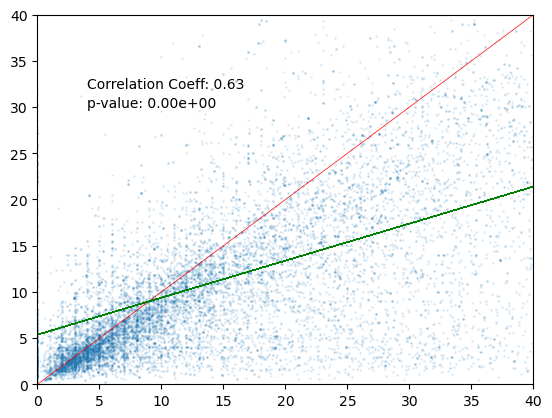

In [112]:
threshold=40

x=points['ptTravelTime']/60
y=points['transit_time']/60

# Remove NaN or None values
valid_indices = np.logical_and(~np.isnan(x), ~np.isnan(y))
x = x[valid_indices]
y = y[valid_indices]

print(x.shape)
x = x[y>0]
y = y[y>0]
print(x.shape)

#x=np.log(x)
#y=np.log(y)

# Fit linear regression model
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)


#plt.plot((points['ptTravelTime']/60),(points['transit_time']/60), 'o', alpha=1./10, ms=1)
plt.plot(x, y, 'o', alpha=1./10, ms=1)

plt.xlim(0, threshold)
plt.ylim(0, threshold)

plt.plot([0, threshold],[0, threshold], color='red', lw=0.5)
plt.plot(x, intercept + slope * x, color='green', label='Regression Line', lw=0.5)

r_squared = r_value ** 2

# Display the regression statistics
#plt.text(0.1, 0.9, f'R-squared: {r_squared:.2f}', transform=plt.gca().transAxes)
#plt.text(0.1, 0.85, f'Slope: {slope:.2f}', transform=plt.gca().transAxes)
plt.text(0.1, 0.8, f'Correlation Coeff: {r_value:.2f}', transform=plt.gca().transAxes)
plt.text(0.1, 0.75, f'p-value: {p_value:.2e}', transform=plt.gca().transAxes)


In [136]:
points.shape

(29175, 9)

In [137]:
points.head()

,itid,walkTravelTime,walkDistance_x,ptTravelTime,walk_time,walkDistance_y,transit_time,SBB_total_travel_time,OTP_total_travel_time
0,BL35006Q-1,168.405733,140.338111,0.0,173,206.91,0,125.519801,173
1,BL35006Q-1,168.405733,140.338111,0.0,173,206.91,0,125.519801,173
2,BL35006Q-2,168.405733,140.338111,0.0,173,206.91,0,125.519801,173
3,BL35006Q-2,168.405733,140.338111,0.0,173,206.91,0,125.519801,173
4,BL35007P-1,448.803406,374.002838,0.0,345,421.27,0,334.511855,345


In [138]:
df2.head()

,itid,walk_time,transit_time,waitingTime,walkDistance,transfers,total_time
0,BL35006Q-1,173,0,0,206.91,0,173
1,BL35006Q-2,173,0,0,206.91,0,173
2,BL35006Q-1,173,0,0,206.91,0,173
3,BL35006Q-2,173,0,0,206.91,0,173
4,BL35007P-1,345,0,0,421.27,0,345


In [139]:
df2.shape

(105767, 7)

In [144]:
df['itid'] = df['IDNumber'] + '-' + df['TripNumber'].astype(str)
df[filtered_df]['itid']

0        BL35006Q-1
1        BL35006Q-2
2        BL35006Q-1
3        BL35006Q-2
4        BL35007P-1
            ...    
31124    WG47610M-5
31125    WG47610M-1
31126    WG47610M-2
31127    WG47611G-1
31128    WG47611G-2
Name: itid, Length: 30508, dtype: object